## Saliency Heatmaps

#### Classes  

Mature Leukocyte:
- 2: EOS – Eosinophil  
- 4: LYA – Lymphocyte (atypical)  
- 5: LYT – Lymphocyte (typical)  
- 7: MOB – Monocyte  
- 0: BAS – Basophil  
- 10: MYO – Myelocyte  
- 11: NGB – Neutrophil (band)  
- 12: NGS – Neutrophil (segmented)  

Immature Leukocyte:
- 1: EBO – Erythroblast  
- 6: MMZ – Metamyelocyte  
- 8: MON – Monoblast  
- 9: MYB – Myeloblast  
- 13: PMB – Promyelocyte (bilobed)  
- 14: PMO – Promyelocyte  

Other:  
- 3: KSC – Smudge cells  

In [64]:
# Loaded Pakcages
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# Images for Heatmaps    DEFINE
# Images from classes with more than 10 images in the training
image_paths = [
    "eval_data/BAS/0.jpg",
    "eval_data/EBO/0.jpg",
    "eval_data/EOS/0.jpg",
    #"eval_data/KSC/0.jpg",
    #"eval_data/LYA/0.jpg",
    "eval_data/LYT/0.jpg",
    #"eval_data/MMZ/0.jpg",
    #"eval_data/MOB/0.jpg",
    "eval_data/MON/0.jpg",
    #"eval_data/MYB/0.jpg",
    "eval_data/MYO/0.jpg",
    "eval_data/NGB/0.jpg",
    "eval_data/NGS/0.jpg",
    #"eval_data/PMB/0.jpg",
    "eval_data/PMO/0.jpg",
]

In [67]:
# Cell classes
idx_to_class = {
    0: "BAS",
    1: "EBO",
    2: "EOS",
    3: "KSC",
    4: "LYA",
    5: "LYT",
    6: "MMZ",
    7: "MOB",
    8: "MON",
    9: "MYB",
    10: "MYO",
    11: "NGB",
    12: "NGS",
    13: "PMB",
    14: "PMO"
}

In [68]:
# Load model
model = models.resnext50_32x4d()
model.fc = nn.Linear(model.fc.in_features, 15)
model.load_state_dict(torch.load("trained_model.pth",map_location=torch.device('cpu'),weights_only=True))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
# Transformation
transform = transforms.Compose([
    #transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

# Prediction and Saliency
def predict_and_saliency(model, img_path):
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0) #batch dimension
    input_tensor.requires_grad_()

    # Prediction
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item() #class with highest logic value, tensor to number

    # Saliency Map
    model.zero_grad()
    output[0, pred_class].backward()
    saliency = input_tensor.grad.data.abs().squeeze().numpy() #removes redundant dimensions
    saliency = np.max(saliency, axis=0) #reduces the channel dimension
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Confidence
    with torch.no_grad():
        probs = torch.softmax(output, dim=1)
        max_prob = probs.max().item() #softmax output

    true_class = os.path.basename(os.path.dirname(img_path))

    return image, saliency, pred_class, max_prob, true_class

In [73]:
# Plots
def plot_results(image, saliency, pred_class, max_prob, true_class):
    plt.figure(figsize=(10,5))

    # Original
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title(f"Original \n True: {true_class} \n Prediction: {idx_to_class[pred_class]}")
    plt.axis("off")

    # Heatmap
    plt.subplot(1,2,2)
    resized_img = image.resize((400, 400)).convert("L")
    plt.imshow(resized_img, cmap="gray")
    plt.imshow(saliency, cmap="hot", alpha=0.6)
    plt.title(f"Heatmap \n Prediction: {idx_to_class[pred_class]} \n Confidence: {max_prob:.2f}")
    plt.axis("off")

    plt.show()

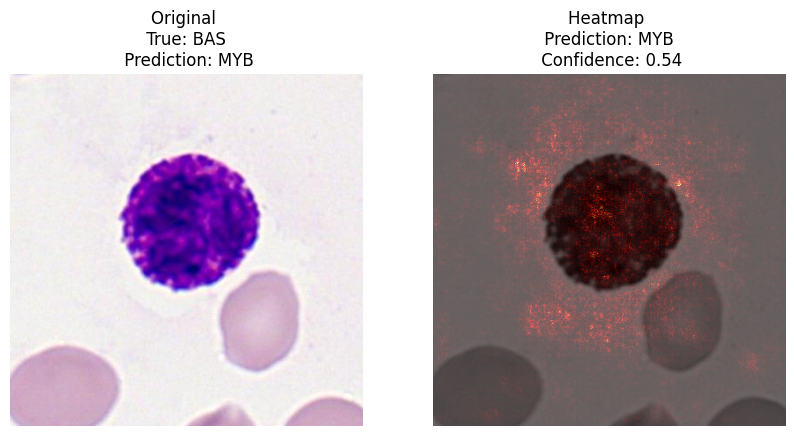

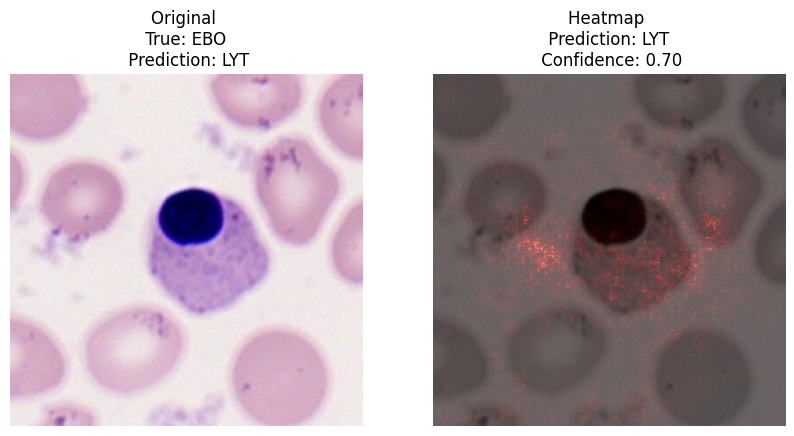

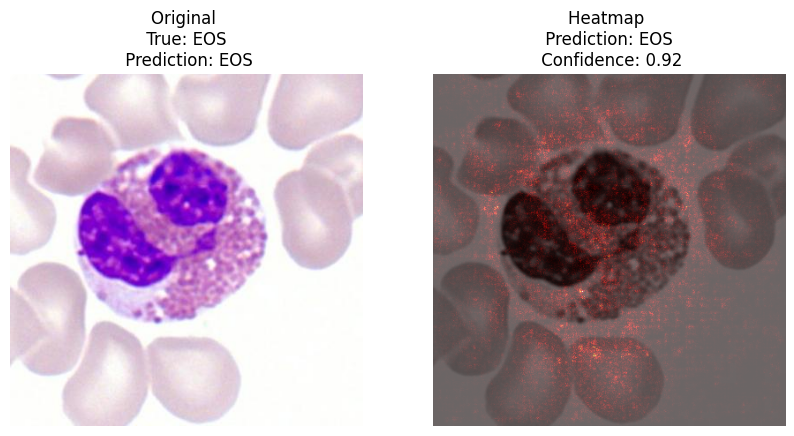

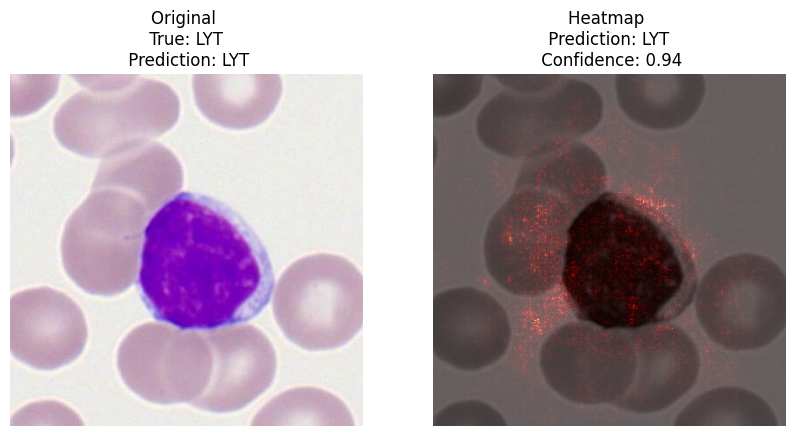

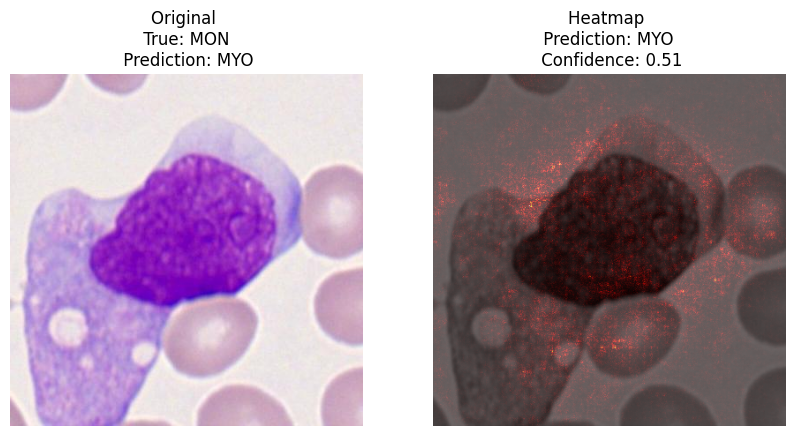

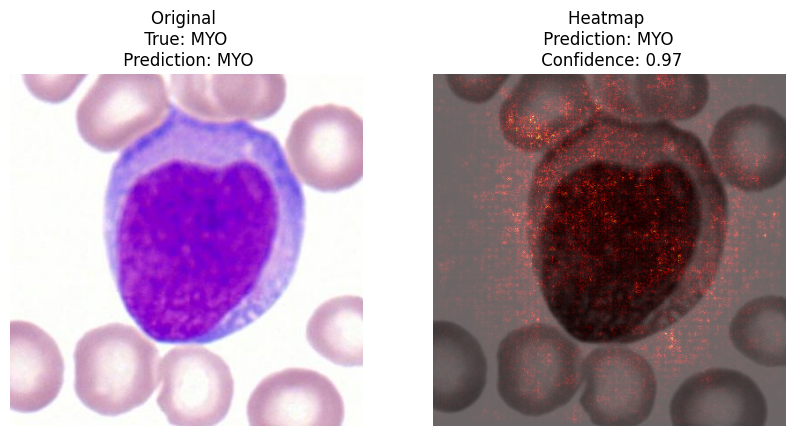

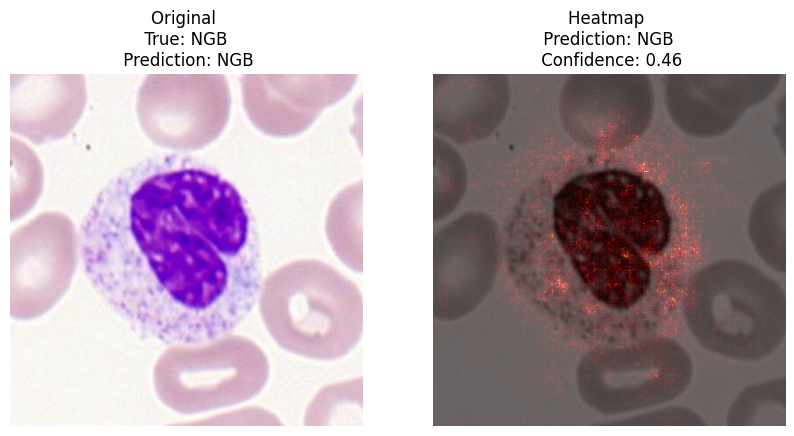

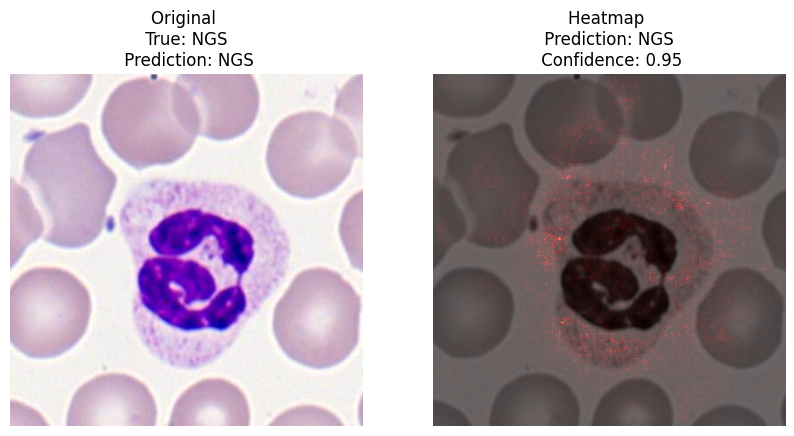

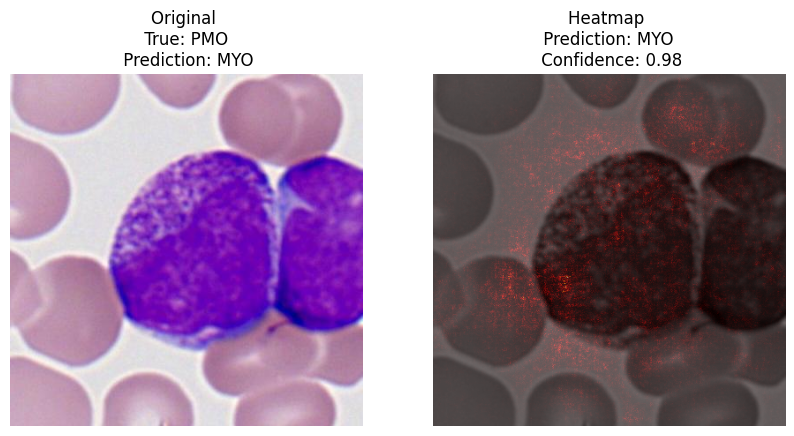

In [ ]:
# Images
for img_path in image_paths:
    image, saliency, pred_class, max_prob, true_class = predict_and_saliency(model, img_path)
    plot_results(image, saliency, pred_class, max_prob, true_class)

In [ ]:
# Images for Documentation
image_paths_test  = [
    # "eval_data/BAS/0.jpg",
    # "eval_data/BAS/1.jpg",
    # "eval_data/BAS/2.jpg",
    # "eval_data/BAS/3.jpg",
    # "eval_data/BAS/4.jpg",
    #"eval_data/EBO/0.jpg",
    # "eval_data/EBO/1.jpg",
    # "eval_data/EBO/2.jpg",
     "eval_data/EBO/3.jpg",
    # "eval_data/EBO/4.jpg",
    # "eval_data/EOS/0.jpg",
    # "eval_data/EOS/1.jpg",
     "eval_data/EOS/2.jpg",
    # "eval_data/EOS/3.jpg",
    # "eval_data/LYT/14.jpg",
    # "eval_data/KSC/0.jpg",
    # "eval_data/LYA/1.jpg",
    # "eval_data/MMZ/2.jpg",
    # "eval_data/MOB/3.jpg",
    # "eval_data/NGB/17.jpg",
    # "eval_data/NGS/0.jpg",
    # "eval_data/PMB/1.jpg",
    # "eval_data/PMO/2.jpg",
    # "eval_data/PMO/8.jpg",
    # "eval_data/PMO/9.jpg",
]

for img_path in image_paths_test:
    image, saliency, pred_class, max_prob, true_class = predict_and_saliency(model, img_path)
    plot_results(image, saliency, pred_class, max_prob, true_class)